In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string
from string import punctuation
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import itertools
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from textblob import TextBlob

In [2]:
df = pd.read_csv("C:/Users/Documents/Projects/Project-2/financial_sentiment_data.csv", index_col = False)

Under Standing the data

In [3]:
df.head()

Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


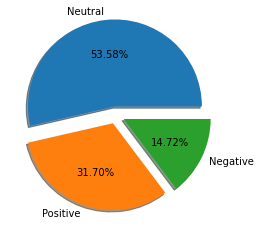

In [5]:
plt.pie(df.Sentiment.value_counts()/len(df), #(neutral=3130, positive = 1852, negative = 860)/5842
        labels =['Neutral','Positive','Negative'],
        autopct='%1.2f%%',shadow=True,explode=(0.1, 0.1,0.1)) 
# autopct is for displaying the percentage. here it is for 2 decimal
# explode for the gap 

plt.show()

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

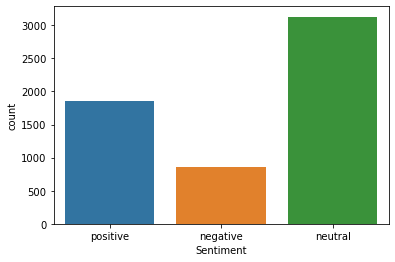

In [6]:
sns.countplot(x='Sentiment',data=df)

In [7]:
#showing the duplicated data
df[df.duplicated()]

Sentence Sentiment
1825  Proha Plc ( Euronext :7327 ) announced today (...   neutral
1859  SSH Communications Security Corporation is hea...   neutral
2672  Ahlstrom 's share is quoted on the NASDAQ OMX ...   neutral
3272  The company serves customers in various indust...   neutral
3986  The issuer is solely responsible for the conte...   neutral
5342  The report profiles 614 companies including ma...   neutral

In [8]:
#Removing the Duplicated data
df.drop_duplicates(inplace=True)

In [9]:
df.describe()

Sentence Sentiment
count                                                5836      5836
unique                                               5322         3
top     Managing Director 's comments : `` Net sales f...   neutral
freq                                                    2      3124

In [10]:
# Group the DataFrame by "Sentence" and count the number of occurrences of each sentence
df_grouped = df.groupby("Sentence").agg({"Sentiment": "nunique"}).reset_index()

In [11]:
df_grouped.describe()

Sentiment
count  5322.000000
mean      1.096580
std       0.295413
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000

In [150]:
df_grouped.shape

(5322, 2)

In [13]:
# Filter out the sentences that only appear once
df_duplicates = df_grouped[df_grouped["Sentiment"] > 1]

In [14]:
df_duplicates.describe()

Sentiment
count      514.0
mean         2.0
std          0.0
min          2.0
25%          2.0
50%          2.0
75%          2.0
max          2.0

In [15]:
# Merge the filtered DataFrame with the original DataFrame to obtain the repeated sentences and their corresponding sentiments
df_repeated = pd.merge(df, df_duplicates, on="Sentence", how="inner")

In [16]:
df_repeated.describe()

Sentiment_y
count       1028.0
mean           2.0
std            0.0
min            2.0
25%            2.0
50%            2.0
75%            2.0
max            2.0

In [17]:
# Remove the repeated sentences from the original DataFrame
df.drop_duplicates(subset="Sentence", keep=False, inplace=True)

In [18]:
df.describe()

Sentence Sentiment
count                                                4808      4808
unique                                               4808         3
top     The GeoSolutions technology will leverage Bene...   neutral
freq                                                    1      2610

In [19]:
df_repeated.head()

Sentence Sentiment_x  Sentiment_y
0  SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...    negative            2
1  SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...     neutral            2
2           Viking Line has canceled some services .     neutral            2
3           Viking Line has canceled some services .    negative            2
4  Dolce & Gabbana has asked the European Union t...    negative            2

In [20]:
df_repeated.drop("Sentiment_x",axis=1, inplace=True)

In [21]:
df_repeated.head()

Sentence  Sentiment_y
0  SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...            2
1  SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...            2
2           Viking Line has canceled some services .            2
3           Viking Line has canceled some services .            2
4  Dolce & Gabbana has asked the European Union t...            2

In [22]:
df_repeated.drop("Sentiment_y",axis=1, inplace=True)

In [23]:
df_repeated.head()

Sentence
0  SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...
1  SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...
2           Viking Line has canceled some services .
3           Viking Line has canceled some services .
4  Dolce & Gabbana has asked the European Union t...

In [24]:
df_repeated.describe()

Sentence
count                                                1028
unique                                                514
top     SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...
freq                                                    2

In [25]:
df_repeated.drop_duplicates(inplace=True)

In [26]:
df_repeated.describe()

Sentence
count                                                 514
unique                                                514
top     SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...
freq                                                    1

In [27]:
def text_normalization(text):
    #1) converting all characters to lower case
    text = text.lower()
    #2) removing punctuations
    punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(punc)
    #2) removing extra white spaces
    text = re.sub('\s+', ' ', text).strip()
    #4) removing special characters
    text = re.sub('[^A-Za-z0-9\s]+', '', text)
    #5) removing numbers
    text = re.sub('\d+', '', text)
    ###5) removing punctuations
    ###text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #6) removing links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    #7) Deleting newlines
    text = re.sub('\n', '', text)
    return text  

In [28]:
df['Sentence'] = df['Sentence'].apply(text_normalization)

In [29]:
df_repeated['Sentence'] = df_repeated['Sentence'].apply(text_normalization)

In [30]:
lemmatizer = WordNetLemmatizer()
Stopwords = set(nltk.corpus.stopwords.words("english")) - set(["not"])

In [31]:
def preprocess_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token not in Stopwords ]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = " ".join(tokens)
    return text

In [32]:
df["Sentence"] = df['Sentence'].apply(preprocess_text)

In [33]:
df_repeated["Sentence"] = df_repeated['Sentence'].apply(preprocess_text)

In [34]:
df.head()

Sentence Sentiment
0  geosolutions technology leverage benefon gps s...  positive
1                        esi low bk real possibility  negative
2  last quarter componenta net sale doubled eurm ...  positive
3  according finnish russian chamber commerce maj...   neutral
4  swedish buyout firm sold remaining percent sta...   neutral

In [35]:
df_repeated.head()

Sentence
0  ssh communication security corp stock exchange...
2                       viking line canceled service
4  dolce gabbana asked european union declare mar...
6        diluted earnings per share eps fell eur eur
8  finnish geosentric net sale decreased eur janu...

In [36]:
df.shape

(4808, 2)

In [37]:
df_repeated.shape

(514, 1)

In [38]:
def getPolarity(Clean_reviews):
  return TextBlob(Clean_reviews).sentiment.polarity
df_repeated['Polarity'] = df_repeated['Sentence'].apply(getPolarity)

In [39]:
df_repeated.head(5)

Sentence  Polarity
0  ssh communication security corp stock exchange...      0.35
2                       viking line canceled service      0.00
4  dolce gabbana asked european union declare mar...      0.00
6        diluted earnings per share eps fell eur eur      0.00
8  finnish geosentric net sale decreased eur janu...     -0.20

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Polarity', ylabel='Density'>

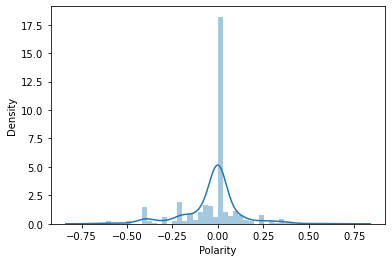

In [40]:
sns.distplot(df_repeated['Polarity'])

In [41]:
def getPolarity(Clean_reviews):
  return TextBlob(Clean_reviews).sentiment.polarity
df['Polarity'] = df['Sentence'].apply(getPolarity)

In [42]:
df.head()

Sentence Sentiment  Polarity
0  geosolutions technology leverage benefon gps s...  positive  0.209091
1                        esi low bk real possibility  negative  0.100000
2  last quarter componenta net sale doubled eurm ...  positive  0.000000
3  according finnish russian chamber commerce maj...   neutral  0.031250
4  swedish buyout firm sold remaining percent sta...   neutral -0.100000

In [44]:
# group by sentiment and calculate the range of polarity
#polarity_range = df.groupby('Sentiment')['Polarity'].agg(['min', 'max'])

In [43]:
# Define the threshold values for each sentiment category
pos_threshold = 0.1
neg_threshold = -0.05 # while taking -0.1 we are getting 8.49%
# Define a function to apply the thresholding and return the predicted sentiment
def get_sentiment(polarity):
    if polarity >= pos_threshold:
        return 'positive'
    elif polarity <= neg_threshold:
        return 'negative'
    else:
        return 'neutral'

In [44]:
df_repeated['Sentiment'] = df_repeated['Polarity'].apply(get_sentiment)

In [45]:
df_repeated.head(5)

Sentence  Polarity Sentiment
0  ssh communication security corp stock exchange...      0.35  positive
2                       viking line canceled service      0.00   neutral
4  dolce gabbana asked european union declare mar...      0.00   neutral
6        diluted earnings per share eps fell eur eur      0.00   neutral
8  finnish geosentric net sale decreased eur janu...     -0.20  negative

In [46]:
df_repeated.drop('Polarity',axis=1, inplace=True)

In [47]:
df_repeated.head(5)

Sentence Sentiment
0  ssh communication security corp stock exchange...  positive
2                       viking line canceled service   neutral
4  dolce gabbana asked european union declare mar...   neutral
6        diluted earnings per share eps fell eur eur   neutral
8  finnish geosentric net sale decreased eur janu...  negative

In [48]:
df3 = pd.concat([df, df_repeated])

In [49]:
df3.shape

(5322, 3)

In [50]:
df3 = df3.reset_index(drop=True)

In [52]:
#df3.describe()
##df4 = df3.copy()
#df4.tail()
#df4.describe()
#df4 = df4.drop_duplicates()
#df4.describe()
# remove duplicates based on a specific column(s)
#df5 = df4.drop_duplicates(subset=[''])

In [56]:
#df4 = df3.copy()

In [57]:
#df4.tail()

In [51]:
#df4.describe()

Sentence Sentiment
count                 5322      5322
unique                5251         3
top     value order eur mn   neutral
freq                     7      2955

In [55]:
#df4 = df4.drop_duplicates()

In [56]:
#df4.describe()

Sentence Sentiment
count                                     5254      5254
unique                                    5251         3
top     operating profit totaled eur mn eur mn   neutral
freq                                         2      2919

In [59]:
#duplicate_rows = df4[df4.duplicated()]

In [60]:
#print(duplicate_rows)

Empty DataFrame
Columns: [Sentence, Sentiment]
Index: []


In [61]:
# remove duplicates based on a specific column(s)
#df5 = df4.drop_duplicates(subset=['Sentence'])

In [62]:
#df5.describe()

Sentence Sentiment
count                                                5251      5251
unique                                               5251         3
top     geosolutions technology leverage benefon gps s...   neutral
freq                                                    1      2916

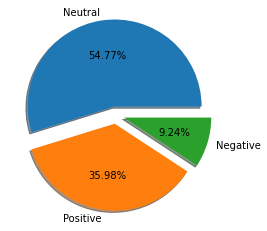

In [53]:
plt.pie(df3.Sentiment.value_counts()/len(df3), #(neutral=3130, positive = 1852, negative = 860)/5842
        labels =['Neutral','Positive','Negative'],
        autopct='%1.2f%%',shadow=True,explode=(0.1, 0.1,0.1)) 
# autopct is for displaying the percentage. here it is for 2 decimal
# explode for the gap 

plt.show()

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

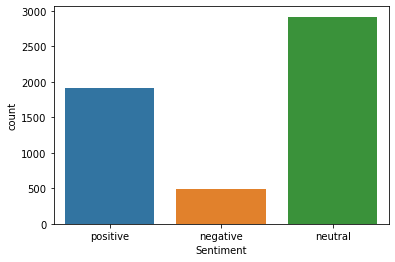

In [54]:
sns.countplot(x='Sentiment',data=df3)

Seperating the Sentences based on sentiment

In [55]:
df_pos = df3[df3['Sentiment']=='positive']
df_neu = df3[df3["Sentiment"]=="neutral"]
df_neg = df3[df3['Sentiment']=='negative']

Positive Sentiment

In [56]:
print(df_pos)

                                               Sentence Sentiment  Polarity
0     geosolutions technology leverage benefon gps s...  positive  0.209091
2     last quarter componenta net sale doubled eurm ...  positive  0.000000
5                         spy surprised see green close  positive -0.050000
7         kone net sale rose year year first nine month  positive  0.283333
9          circulation revenue increased finland sweden  positive  0.000000
...                                                 ...       ...       ...
5282                            export good fell import  positive       NaN
5292  based first quarter result existing order back...  positive       NaN
5294  nordic bank already write sizable loan latvia ...  positive       NaN
5312  finnish business software group affectogenimap...  positive       NaN
5315  kone said court paper union action delayed rep...  positive       NaN

[1915 rows x 3 columns]


In [57]:
tokenized_text_pos = ' '.join(df_pos['Sentence']).split()

In [58]:
print(tokenized_text_pos)

['geosolutions', 'technology', 'leverage', 'benefon', 'gps', 'solution', 'providing', 'location', 'based', 'search', 'technology', 'community', 'platform', 'location', 'relevant', 'multimedia', 'content', 'new', 'powerful', 'commercial', 'model', 'last', 'quarter', 'componenta', 'net', 'sale', 'doubled', 'eurm', 'eurm', 'period', 'year', 'earlier', 'moved', 'zero', 'pre', 'tax', 'profit', 'pre', 'tax', 'loss', 'eurm', 'spy', 'surprised', 'see', 'green', 'close', 'kone', 'net', 'sale', 'rose', 'year', 'year', 'first', 'nine', 'month', 'circulation', 'revenue', 'increased', 'finland', 'sweden', 'subdivision', 'made', 'sale', 'revenue', 'last', 'year', 'eur', 'million', 'eur', 'million', 'operating', 'profit', 'eur', 'million', 'eur', 'million', 'fb', 'gone', 'green', 'day', 'msft', 'sql', 'server', 'revenue', 'grew', 'double', 'digit', 'sql', 'server', 'premium', 'revenue', 'growing', 'http', 'stks', 'co', 'irf', 'aviva', 'friend', 'life', 'top', 'forecast', 'ahead', 'billion', 'pound', 

counter = it will return a dictionary-like object elements in the list and the values are the number of times each element appears in the list.

In [59]:
from collections import Counter
word_counts_pos = Counter(tokenized_text_pos)

printing the most common 10 positive words

In [60]:
print(word_counts_pos.most_common(10))

[('eur', 619), ('mn', 270), ('year', 251), ('company', 247), ('sale', 241), ('profit', 225), ('net', 210), ('said', 204), ('finnish', 192), ('co', 180)]


In [61]:
print(type(word_counts_pos))

<class 'collections.Counter'>


In [62]:
print(word_counts_pos)

Counter({'eur': 619, 'mn': 270, 'year': 251, 'company': 247, 'sale': 241, 'profit': 225, 'net': 210, 'said': 204, 'finnish': 192, 'co': 180, 'million': 174, 'http': 174, 'period': 152, 'quarter': 143, 'mln': 133, 'operating': 126, 'share': 119, 'group': 109, 'new': 99, 'first': 98, 'market': 97, 'euro': 95, 'rose': 94, 'stks': 92, 'increased': 90, 'oyj': 90, 'service': 90, 'today': 87, 'long': 84, 'loss': 82, 'percent': 77, 'increase': 76, 'compared': 76, 'business': 74, 'buy': 70, 'finland': 69, 'month': 68, 'corresponding': 67, 'also': 65, 'order': 64, 'price': 62, 'operation': 62, 'contract': 62, 'growth': 55, 'aapl': 55, 'solution': 53, 'agreement': 53, 'stock': 51, 'last': 50, 'technology': 49, 'per': 48, 'hel': 46, 'cost': 45, 'earnings': 44, 'signed': 44, 'result': 43, 'customer': 43, 'high': 43, 'product': 43, 'higher': 42, 'system': 41, 'plc': 41, 'u': 40, 'good': 40, 'eurm': 39, 'earlier': 39, 'billion': 39, 'maker': 39, 'deal': 39, 'bank': 39, 'revenue': 38, 'line': 38, 'sec

Word cloud for Positive Sentiment

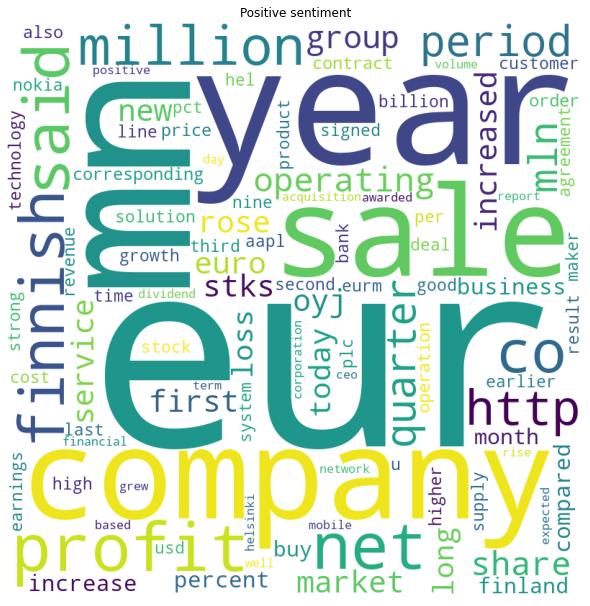

In [63]:
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(word_counts_pos)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Positive sentiment')
plt.show()

word cloud for neutral sentiment

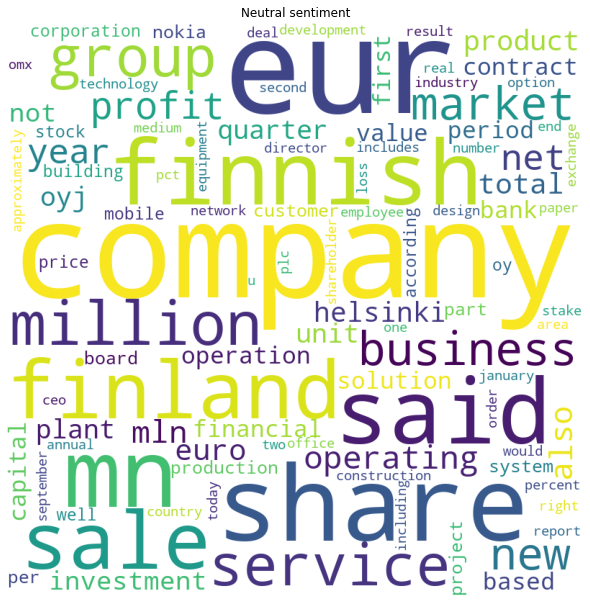

In [64]:
tokenized_text_neu = ' '.join(df_neu['Sentence']).split()
word_counts_neu = Counter(tokenized_text_neu)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(word_counts_neu)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Neutral sentiment')
plt.show()

word cloud for negative sentiment

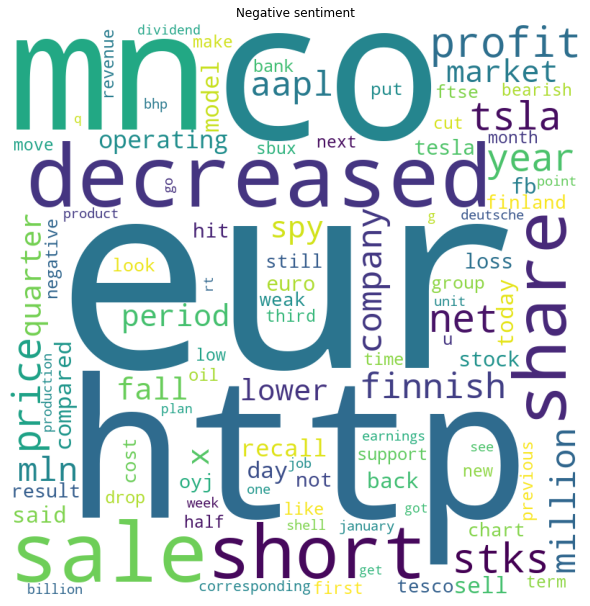

In [65]:
tokenized_text_neg = ' '.join(df_neg['Sentence']).split()
word_counts_neg = Counter(tokenized_text_neg)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(word_counts_neg)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Negative sentiment')
plt.show()

word cloud for all sentiments

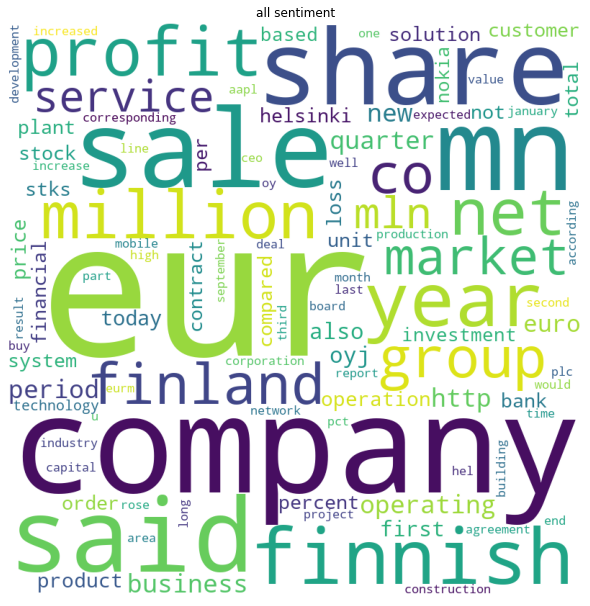

In [66]:
df_all = df3["Sentence"]
tokenized_text_all = ' '.join(df_all).split()
word_counts_all = Counter(tokenized_text_all)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(word_counts_all)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('all sentiment')
plt.show()

for all sentiments

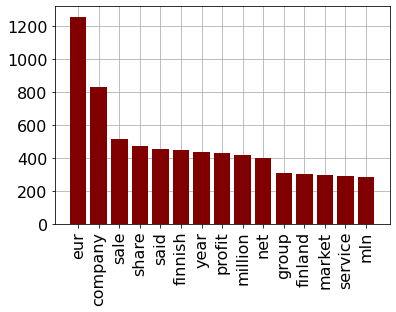

In [67]:
tokens_all = [word_tokenize(review) for review in tokenized_text_all]
all_tokens = [[word for word in item if len(word) > 2] for item in tokens_all]
last_token = list(itertools.chain(*all_tokens)) 
bow_all = Counter(last_token).most_common(15) ### Displays the 15 most common words in all articles of the dataset.
labels = [item[0] for item in bow_all]
number = [item[1] for item in bow_all]
nbars = len(bow_all)
plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

for positive sentiments

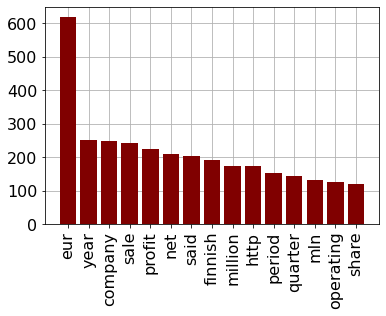

In [68]:
tokens_pos = [word_tokenize(review) for review in tokenized_text_pos]
pos_tokens = [[word for word in item if len(word) > 2] for item in tokens_pos]
last_token = list(itertools.chain(*pos_tokens)) 
bow_pos = Counter(last_token).most_common(15) ### Displays the 15 most common words in pos articles of the dataset.
labels = [item[0] for item in bow_pos]
number = [item[1] for item in bow_pos]
nbars = len(bow_pos)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

for negative sentiments

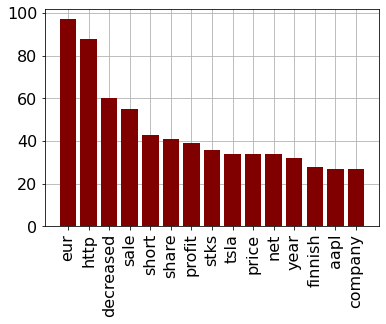

In [69]:
tokens_neg = [word_tokenize(review) for review in tokenized_text_neg]
neg_tokens = [[word for word in item if len(word) > 2] for item in tokens_neg]
last_token = list(itertools.chain(*neg_tokens)) 
bow_neg = Counter(last_token).most_common(15) ### Displays the 15 most common words in neg articles of the dataset.
labels = [item[0] for item in bow_neg]
number = [item[1] for item in bow_neg]
nbars = len(bow_neg)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()


for neutral sentiments

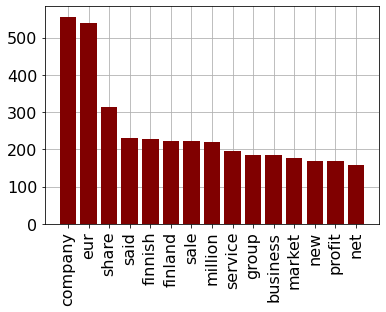

In [70]:
tokens_neu = [word_tokenize(review) for review in tokenized_text_neu]
neu_tokens = [[word for word in item if len(word) > 2] for item in tokens_neu]
last_token = list(itertools.chain(*neu_tokens)) 
bow_neu = Counter(last_token).most_common(15) ### Displays the 15 most common words in neu articles of the dataset.
labels = [item[0] for item in bow_neu]
number = [item[1] for item in bow_neu]
nbars = len(bow_neu)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

printing of all tokenized text of types of sentiments

In [71]:
print(tokenized_text_all)

['geosolutions', 'technology', 'leverage', 'benefon', 'gps', 'solution', 'providing', 'location', 'based', 'search', 'technology', 'community', 'platform', 'location', 'relevant', 'multimedia', 'content', 'new', 'powerful', 'commercial', 'model', 'esi', 'low', 'bk', 'real', 'possibility', 'last', 'quarter', 'componenta', 'net', 'sale', 'doubled', 'eurm', 'eurm', 'period', 'year', 'earlier', 'moved', 'zero', 'pre', 'tax', 'profit', 'pre', 'tax', 'loss', 'eurm', 'according', 'finnish', 'russian', 'chamber', 'commerce', 'major', 'construction', 'company', 'finland', 'operating', 'russia', 'swedish', 'buyout', 'firm', 'sold', 'remaining', 'percent', 'stake', 'almost', 'eighteen', 'month', 'taking', 'company', 'public', 'finland', 'spy', 'surprised', 'see', 'green', 'close', 'shell', 'billion', 'bg', 'deal', 'meet', 'shareholder', 'skepticism', 'kone', 'net', 'sale', 'rose', 'year', 'year', 'first', 'nine', 'month', 'stockmann', 'department', 'store', 'total', 'floor', 'space', 'square', 'm

In [72]:
print(tokenized_text_neg)

['esi', 'low', 'bk', 'real', 'possibility', 'shell', 'billion', 'bg', 'deal', 'meet', 'shareholder', 'skepticism', 'sap', 'q', 'disappoints', 'software', 'license', 'real', 'problem', 'cloud', 'growth', 'trail', 'msft', 'orcl', 'goog', 'crm', 'adbe', 'http', 'co', 'jndphllzq', 'aapl', 'afternoon', 'selloff', 'usual', 'brutal', 'get', 'ready', 'lose', 'ton', 'money', 'tsla', 'recalling', 'pretty', 'much', 'every', 'single', 'model', 'x', 'cnnbrk', 'got', 'short', 'even', 'work', 'jump', 'money', 'trade', 'intercontinental', 'hotel', 'first', 'quarter', 'global', 'room', 'revenue', 'lag', 'estimate', 'l', 'g', 'still', 'paying', 'price', 'dividend', 'cut', 'crisis', 'chief', 'say', 'astrazeneca', 'profit', 'sale', 'stalwart', 'fade', 'u', 'sanction', 'put', 'gazprom', 'shell', 'alliance', 'plan', 'jeopardy', 'tesco', 'share', 'price', 'grocer', 'face', 'sfo', 'investigation', 'outcome', 'tsla', 'recall', 'googl', 'short', 'upper', 'bb', 'overbought', 'tesla', 'recalling', 'model', 'x', '

In [73]:
print(tokenized_text_neu)

['according', 'finnish', 'russian', 'chamber', 'commerce', 'major', 'construction', 'company', 'finland', 'operating', 'russia', 'swedish', 'buyout', 'firm', 'sold', 'remaining', 'percent', 'stake', 'almost', 'eighteen', 'month', 'taking', 'company', 'public', 'finland', 'stockmann', 'department', 'store', 'total', 'floor', 'space', 'square', 'metre', 'stockmann', 'investment', 'project', 'price', 'tag', 'eur', 'million', 'ahlstrom', 'corporation', 'stock', 'exchange', 'announcement', 'total', 'new', 'share', 'ahlstrom', 'corporation', 'subscribed', 'option', 'right', 'company', 'stock', 'option', 'program', 'ii', 'according', 'l', 'nnen', 'tehtaat', 'ceo', 'matti', 'karppinen', 'company', 'aim', 'deliver', 'fish', 'product', 'customer', 'day', 'earlier', 'currently', 'company', 'share', 'quoted', 'nasdaq', 'omx', 'helsinki', 'rautaruukki', 'oyj', 'rtrks', 'elcoteq', 'se', 'listed', 'nasdaq', 'omx', 'helsinki', 'ltd', 'two', 'contract', 'turntable', 'anode', 'vibrocompactors', 'deliver

In [74]:
print(tokenized_text_pos)

['geosolutions', 'technology', 'leverage', 'benefon', 'gps', 'solution', 'providing', 'location', 'based', 'search', 'technology', 'community', 'platform', 'location', 'relevant', 'multimedia', 'content', 'new', 'powerful', 'commercial', 'model', 'last', 'quarter', 'componenta', 'net', 'sale', 'doubled', 'eurm', 'eurm', 'period', 'year', 'earlier', 'moved', 'zero', 'pre', 'tax', 'profit', 'pre', 'tax', 'loss', 'eurm', 'spy', 'surprised', 'see', 'green', 'close', 'kone', 'net', 'sale', 'rose', 'year', 'year', 'first', 'nine', 'month', 'circulation', 'revenue', 'increased', 'finland', 'sweden', 'subdivision', 'made', 'sale', 'revenue', 'last', 'year', 'eur', 'million', 'eur', 'million', 'operating', 'profit', 'eur', 'million', 'eur', 'million', 'fb', 'gone', 'green', 'day', 'msft', 'sql', 'server', 'revenue', 'grew', 'double', 'digit', 'sql', 'server', 'premium', 'revenue', 'growing', 'http', 'stks', 'co', 'irf', 'aviva', 'friend', 'life', 'top', 'forecast', 'ahead', 'billion', 'pound', 

To remove the top 75 words which are common in positive, negative, neutral

Caluclating for all the common words

In [75]:
## # here we get ouput type is set

# finding the common words in the entire list
duplicates = set(x for x in tokenized_text_all if tokenized_text_all.count(x)>1)
#print(duplicates)
# finding the common words which are present in all types of  sentiments
common_duplicates = set(x for x in duplicates if x in tokenized_text_pos and x in tokenized_text_neg and x in tokenized_text_neu)
len(common_duplicates)

984

In [76]:
print(common_duplicates)

{'dec', 'nearly', 'minute', 'k', 'trading', 'record', 'learning', 'test', 'bln', 'rally', 'exit', 'marketwatch', 'slipped', 'q', 'resistance', 'google', 'said', 'covered', 'lost', 'berkshire', 'emerging', 'ftse', 'phase', 'video', 'aapl', 'half', 'present', 'bond', 'executive', 'employed', 'rest', 'axa', 'administration', 'billion', 'estimate', 'machine', 'strategic', 'relative', 'tikanoja', 'win', 'telenor', 'china', 'review', 'exchange', 'analyst', 'issue', 'drop', 'global', 'xac', 'much', 'rb', 'average', 'not', 'totaled', 'eps', 'asa', 'subscription', 'pre', 'deutsche', 'idea', 'impact', 'finland', 'compared', 'general', 'speed', 'ipad', 'advertising', 'support', 'factory', 'bounce', 'previous', 'towards', 'bid', 'dividend', 'unit', 'without', 'w', 'ta', 'daily', 'exel', 'lay', 'far', 'player', 'enso', 'fb', 'reported', 'debt', 'grimaldi', 'enterprise', 'supply', 'policy', 'motor', 'negative', 'dt', 'back', 'london', 'public', 'gain', 'return', 'month', 'program', 'technology', 'at

In [77]:
# here we get output type is list

# finding unique items for postive sentiment
tokenized_text_pos
unique_items_pos = []
for item in tokenized_text_pos:
    if item not in unique_items_pos:
        unique_items_pos.append(item)
print(unique_items_pos)
# finding unique items for negative sentiment
tokenized_text_neg
unique_items_neg = []
for item in tokenized_text_neg:
    if item not in unique_items_neg:
        unique_items_neg.append(item)
print(unique_items_neg)
# finding unique items for neutral sentiment
tokenized_text_neu
unique_items_neu = []
for item in tokenized_text_neu:
    if item not in unique_items_neu:
        unique_items_neu.append(item)
print(unique_items_neu)
# the words which are common in the neutral, negative, sentiment
common_words = []
for word in unique_items_pos:
    if word in unique_items_neg and word in unique_items_neu:
        common_words.append(word)

['geosolutions', 'technology', 'leverage', 'benefon', 'gps', 'solution', 'providing', 'location', 'based', 'search', 'community', 'platform', 'relevant', 'multimedia', 'content', 'new', 'powerful', 'commercial', 'model', 'last', 'quarter', 'componenta', 'net', 'sale', 'doubled', 'eurm', 'period', 'year', 'earlier', 'moved', 'zero', 'pre', 'tax', 'profit', 'loss', 'spy', 'surprised', 'see', 'green', 'close', 'kone', 'rose', 'first', 'nine', 'month', 'circulation', 'revenue', 'increased', 'finland', 'sweden', 'subdivision', 'made', 'eur', 'million', 'operating', 'fb', 'gone', 'day', 'msft', 'sql', 'server', 'grew', 'double', 'digit', 'premium', 'growing', 'http', 'stks', 'co', 'irf', 'aviva', 'friend', 'life', 'top', 'forecast', 'ahead', 'billion', 'pound', 'merger', 'shire', 'ceo', 'step', 'drive', 'get', 'baxalta', 'board', 'talking', 'costco', 'premier', 'retail', 'dividend', 'play', 'facnhtt', 'cost', 'stockmann', 'swedish', 'sector', 'company', 'ab', 'lindex', 'entered', 'agreement'

['according', 'finnish', 'russian', 'chamber', 'commerce', 'major', 'construction', 'company', 'finland', 'operating', 'russia', 'swedish', 'buyout', 'firm', 'sold', 'remaining', 'percent', 'stake', 'almost', 'eighteen', 'month', 'taking', 'public', 'stockmann', 'department', 'store', 'total', 'floor', 'space', 'square', 'metre', 'investment', 'project', 'price', 'tag', 'eur', 'million', 'ahlstrom', 'corporation', 'stock', 'exchange', 'announcement', 'new', 'share', 'subscribed', 'option', 'right', 'program', 'ii', 'l', 'nnen', 'tehtaat', 'ceo', 'matti', 'karppinen', 'aim', 'deliver', 'fish', 'product', 'customer', 'day', 'earlier', 'currently', 'quoted', 'nasdaq', 'omx', 'helsinki', 'rautaruukki', 'oyj', 'rtrks', 'elcoteq', 'se', 'listed', 'ltd', 'two', 'contract', 'turntable', 'anode', 'vibrocompactors', 'delivered', 'gansu', 'hualu', 'aluminum', 'co', 'another', 'unnamed', 'costumer', 'stead', 'based', 'soft', 'drink', 'usual', 'teho', 'energy', 'made', 'fresh', 'water', 'plan', 'in

In [78]:
print(len(common_words))
print(type(common_words))

984
<class 'list'>


In [79]:
print(common_words)

['technology', 'gps', 'solution', 'based', 'search', 'new', 'model', 'last', 'quarter', 'net', 'sale', 'eurm', 'period', 'year', 'earlier', 'moved', 'pre', 'tax', 'profit', 'loss', 'see', 'green', 'close', 'rose', 'first', 'nine', 'month', 'revenue', 'increased', 'finland', 'sweden', 'made', 'eur', 'million', 'operating', 'fb', 'day', 'double', 'http', 'stks', 'co', 'aviva', 'life', 'top', 'ahead', 'billion', 'pound', 'merger', 'ceo', 'step', 'get', 'dividend', 'play', 'cost', 'stockmann', 'sector', 'company', 'ab', 'september', 'subsidiary', 'make', 'public', 'share', 'group', 'royal', 'dutch', 'shell', 'buy', 'bg', 'nearly', 'item', 'restructuring', 'eps', 'per', 'according', 'finnish', 'pension', 'two', 'third', 'earnings', 'related', 'cover', 'part', 'patent', 'phone', 'maker', 'nokia', 'oyj', 'also', 'estimate', 'already', 'carried', 'investment', 'lead', 'increase', 'brewery', 'percent', 'growth', 'domestic', 'beer', 'sold', 'result', 'mn', 'corresponding', 'project', 'resource',

In [80]:
print("for words is", type(common_words))
print("for duplicate is",type(common_duplicates))

for words is <class 'list'>
for duplicate is <class 'set'>


to convert collections.counter we need to convert it to dictonaries and then data frame for removal of top 75 words

In [81]:
word_counts_all = Counter(tokenized_text_all)

In [82]:
type(word_counts_all)

collections.Counter

In [83]:
print(word_counts_all.most_common(10))

[('eur', 1256), ('company', 830), ('mn', 588), ('sale', 517), ('share', 473), ('said', 452), ('finnish', 448), ('year', 434), ('profit', 432), ('million', 420)]


In [84]:
counts_dict_all = dict(word_counts_all)

In [85]:
# converting dictonary to data frames for all words
df_1 = pd.DataFrame.from_dict(counts_dict_all, orient = 'index', columns = ['count of words'])
df_1.reset_index(inplace= True)

In [86]:
df_1.rename(columns={'index':'words'}, inplace = True)

In [87]:
df_1

words  count of words
0     geosolutions               2
1       technology             115
2         leverage               3
3          benefon              10
4              gps               6
...            ...             ...
9295      varpaisj               1
9296        halved               1
9297    courthouse               1
9298   saltonstall               1
9299          flew               1

[9300 rows x 2 columns]

In [88]:
# arranging them in descending order
df_1 = df_1.sort_values('count of words', ascending = False)

In [89]:
df_1.shape

(9300, 2)

In [90]:
#  filtering the words
filtered_df = df_1[df_1["words"].isin(common_words)]

In [91]:
df_2 = filtered_df.head(75)

In [92]:
df_2.shape

(75, 2)

In [93]:
df_2 = df_2.drop('count of words', axis=1)

In [94]:
words_75 = df_2['words'].tolist()

In [95]:
print(words_75)

['eur', 'company', 'mn', 'sale', 'share', 'said', 'finnish', 'year', 'profit', 'million', 'net', 'group', 'finland', 'market', 'co', 'service', 'mln', 'operating', 'new', 'http', 'business', 'quarter', 'period', 'euro', 'oyj', 'also', 'first', 'today', 'price', 'loss', 'product', 'operation', 'contract', 'solution', 'helsinki', 'stock', 'compared', 'total', 'bank', 'percent', 'stks', 'per', 'plant', 'order', 'unit', 'system', 'not', 'financial', 'customer', 'investment', 'nokia', 'based', 'technology', 'corresponding', 'corporation', 'month', 'long', 'result', 'capital', 'project', 'mobile', 'well', 'report', 'according', 'increase', 'u', 'production', 'increased', 'deal', 'one', 'rose', 'hel', 'plc', 'part', 'industry']


Removing all the 75 words from all types of Sentiments

In [96]:
# removing the 75 words in pos
pos_words = [word for word in words_75 if word not in tokenized_text_pos] + [word for word in tokenized_text_pos if word not in words_75]
# removing the 75 words in neg
neg_words = [word for word in words_75 if word not in tokenized_text_neg] + [word for word in tokenized_text_neg if word not in words_75]
# removing the 75 words in neu
neu_words = [word for word in words_75 if word not in tokenized_text_neu] + [word for word in tokenized_text_neu if word not in words_75]
# removing the 75 words in all
all_words = [word for word in words_75 if word not in tokenized_text_all] + [word for word in tokenized_text_all if word not in words_75]

for positive words

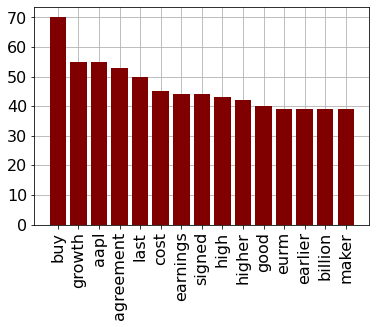

In [97]:
tokens_pos = [word_tokenize(review) for review in pos_words]
pos_tokens = [[word for word in item if len(word) > 2] for item in tokens_pos]
last_token = list(itertools.chain(*pos_tokens)) 
bow_pos = Counter(last_token).most_common(15) ### Displays the 15 most common words in pos articles of the dataset.
labels = [item[0] for item in bow_pos]
number = [item[1] for item in bow_pos]
nbars = len(bow_pos)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

for negatvie words

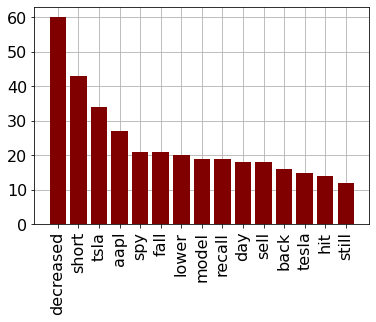

In [98]:
tokens_neg = [word_tokenize(review) for review in neg_words]
neg_tokens = [[word for word in item if len(word) > 2] for item in tokens_neg]
last_token = list(itertools.chain(*neg_tokens)) 
bow_neg = Counter(last_token).most_common(15) ### Displays the 15 most common words in neg articles of the dataset.
labels = [item[0] for item in bow_neg]
number = [item[1] for item in bow_neg]
nbars = len(bow_neg)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

for neutral words

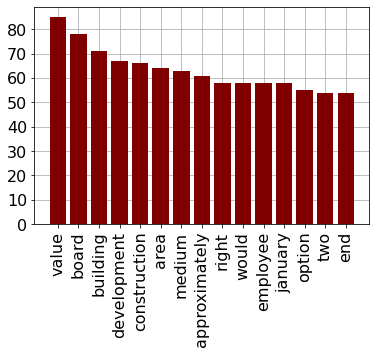

In [99]:
tokens_neu = [word_tokenize(review) for review in neu_words]
neu_tokens = [[word for word in item if len(word) > 2] for item in tokens_neu]
last_token = list(itertools.chain(*neu_tokens)) 
bow_neu = Counter(last_token).most_common(15) ### Displays the 15 most common words in neu articles of the dataset.
labels = [item[0] for item in bow_neu]
number = [item[1] for item in bow_neu]
nbars = len(bow_neu)

plt.grid(zorder=0)
plt.bar(np.arange(nbars), number, tick_label=labels,color ='maroon',zorder=3)
plt.xticks(rotation=90,fontsize=16)
plt.yticks(fontsize=16)
plt.show()

word cloud after removing 75 words

Positive Sentiment

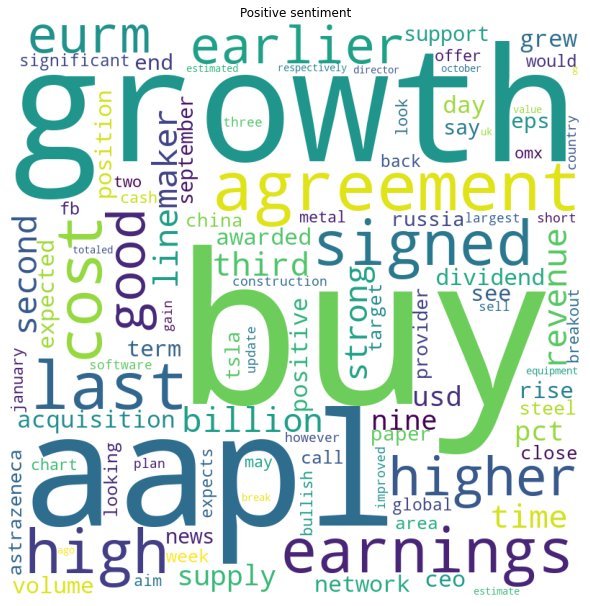

In [100]:
wc_pos_words = Counter(pos_words)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(wc_pos_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Positive sentiment')
plt.show()

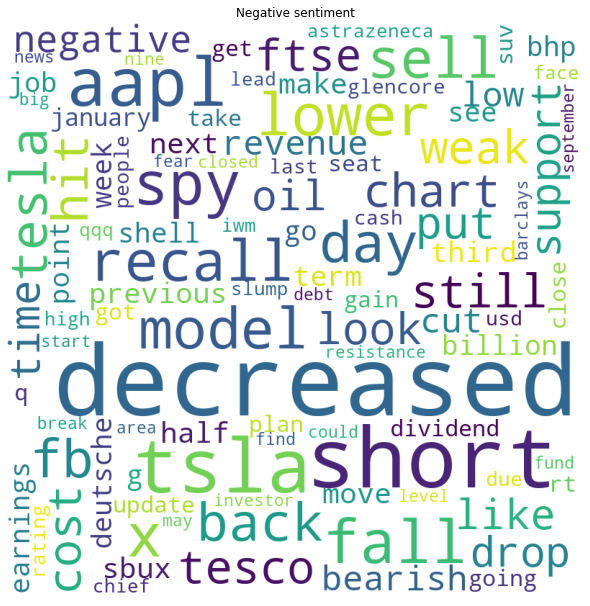

In [101]:
#Negative Sentiment
wc_neg_words = Counter(neg_words)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(wc_neg_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Negative sentiment')
plt.show()

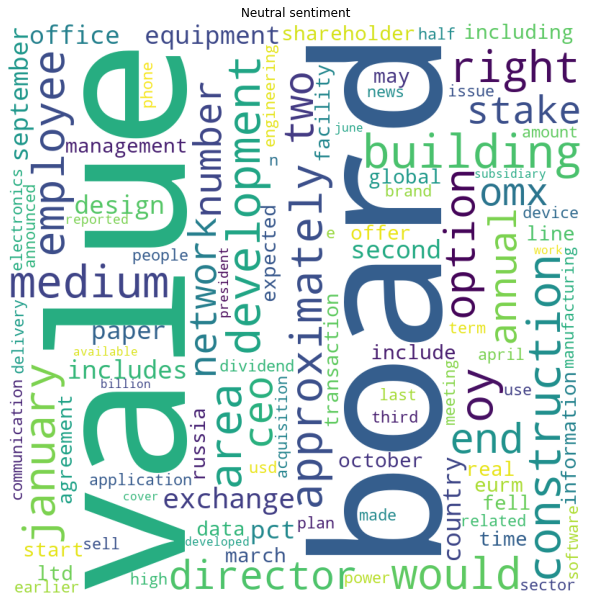

In [102]:
#for neutral sentiment
wc_neu_words = Counter(neu_words)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(wc_neu_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Neutral sentiment')
plt.show()

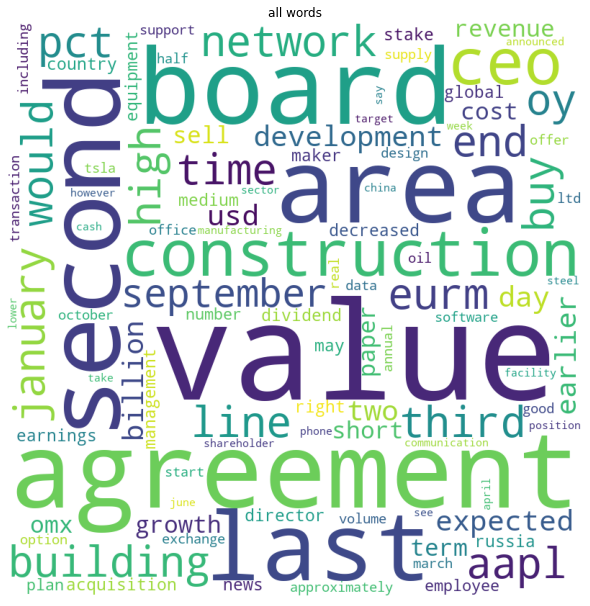

In [103]:
#for all types of sentiment
wc_all_words = Counter(all_words)
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(wc_all_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('all words')
plt.show()


In [104]:
uni_pos = set(pos_words)
print(type(uni_pos))
print(len(uni_pos))

<class 'set'>
4862


In [105]:
uni_neg = set(neg_words)
print(type(uni_neg))
print(len(uni_neg))

<class 'set'>
1906


In [106]:
uni_neu = set(neu_words)
print(type(uni_neu))
print(len(uni_neu))

<class 'set'>
6362


In [107]:
df3.head(5)

Sentence Sentiment  Polarity
0  geosolutions technology leverage benefon gps s...  positive  0.209091
1                        esi low bk real possibility  negative  0.100000
2  last quarter componenta net sale doubled eurm ...  positive  0.000000
3  according finnish russian chamber commerce maj...   neutral  0.031250
4  swedish buyout firm sold remaining percent sta...   neutral -0.100000

In [108]:
#removing the words after removing 75 words
def remove_words_not_in_set(sentence, word_set):
    # Split sentence into list of words
    words = sentence.split()
    # Filter out words not in set
    filtered_words = [word for word in words if word in word_set]
    # Join filtered words back into a sentence
    filtered_sentence = ' '.join(filtered_words)
    return filtered_sentence

In [109]:
# Apply function to each sentence in data
filtered_sentences = []
for sentence, sentiment in zip(df3['Sentence'], df3['Sentiment']):
    if sentiment == 'positive':
        filtered_sentence = remove_words_not_in_set(sentence, pos_words)# any dupicates found change this pos_words = uni_pos
    elif sentiment == 'negative':
        filtered_sentence = remove_words_not_in_set(sentence, neg_words)
    else:
        filtered_sentence = remove_words_not_in_set(sentence, neu_words)
    filtered_sentences.append(filtered_sentence)

creating the a new column for the filtered sentences

In [110]:
df3['Filtered_Sentence'] = filtered_sentences

In [111]:
df3.head()

Sentence Sentiment  Polarity  \
0  geosolutions technology leverage benefon gps s...  positive  0.209091   
1                        esi low bk real possibility  negative  0.100000   
2  last quarter componenta net sale doubled eurm ...  positive  0.000000   
3  according finnish russian chamber commerce maj...   neutral  0.031250   
4  swedish buyout firm sold remaining percent sta...   neutral -0.100000   

                                   Filtered_Sentence  
0  geosolutions leverage benefon gps providing lo...  
1                        esi low bk real possibility  
2  last componenta doubled eurm eurm earlier move...  
3  russian chamber commerce major construction ru...  
4  swedish buyout firm sold remaining stake almos...

In [112]:
df3 = df3[["Filtered_Sentence", "Sentiment"]]

In [113]:
df3.head()

Filtered_Sentence Sentiment
0  geosolutions leverage benefon gps providing lo...  positive
1                        esi low bk real possibility  negative
2  last componenta doubled eurm eurm earlier move...  positive
3  russian chamber commerce major construction ru...   neutral
4  swedish buyout firm sold remaining stake almos...   neutral

In [114]:
# Count the number of rows with each predicted sentiment value
sentiment_counts = df3['Sentiment'].value_counts()
print(sentiment_counts)

neutral     2915
positive    1915
negative     492
Name: Sentiment, dtype: int64


here we are observing there is a class imbalance. to avoid the class imbalance we are using weighted loss function

In [115]:
# Convert sentiment labels to numerical values
df3["Sentiment"] = df3["Sentiment"].map({"negative": 0, "positive": 1, "neutral": 2})

In [116]:
df3.head()

Filtered_Sentence  Sentiment
0  geosolutions leverage benefon gps providing lo...          1
1                        esi low bk real possibility          0
2  last componenta doubled eurm eurm earlier move...          1
3  russian chamber commerce major construction ru...          2
4  swedish buyout firm sold remaining stake almos...          2

Model Building

In [117]:
X = df3['Filtered_Sentence']
y = df3['Sentiment']

In [118]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4257,)
y_train shape: (4257,)
X_test shape: (1065,)
y_test shape: (1065,)


Multinomial Naiive Bayes

In [120]:
# Initialize a dictionary to store the ngram_range and corresponding shapes
shapes = {}

"sample_weight" parameter that allows you to assign a weight to each training sample.

In [121]:

# Loop through different ngram_ranges and fit and transform the features
for ngram_range in [(1,2), (1,3), (2,4)]:
    
    # Vectorize the features using a CountVectorizer with the current ngram_range and max_features=10000
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=10000)
    X_train_transformed = vectorizer.fit_transform(X_train)
    X_test_transformed = vectorizer.transform(X_test)
    
    # Store the shape of the transformed features in the shapes dictionary
    shapes[ngram_range] = X_train_transformed.shape
    
    # Calculate the class weights
    class_weights = {
        2: 1.0,  # Neutral class weight
        1: len(y_train) / sum(y_train==1),  # Positive class weight
        0: len(y_train) / sum(y_train==0)  # Negative class weight
    }
    # Initialize a Naive Bayes model with weighted loss function
    model = MultinomialNB(class_prior=None, fit_prior=True)

    # Fit the model with weighted loss function
    model.fit(X_train_transformed, y_train, sample_weight=[class_weights[c] for c in y_train])

    # Predict the sentiment for the testing set
    y_pred = model.predict(X_test_transformed)
    print(f"y_pred shape: {y_pred.shape}")
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Ngram range: {ngram_range}')
    print(f'Shape of transformed features: {shapes[ngram_range]}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(metrics.classification_report(y_test,y_pred))
    print('------------------------')


y_pred shape: (1065,)
Ngram range: (1, 2)
Shape of transformed features: (4257, 10000)
Accuracy: 0.6460093896713615
Precision: 0.7012031233212987
Recall: 0.6460093896713615
              precision    recall  f1-score   support

           0       0.35      0.59      0.44        95
           1       0.55      0.69      0.61       372
           2       0.85      0.63      0.72       598

    accuracy                           0.65      1065
   macro avg       0.58      0.64      0.59      1065
weighted avg       0.70      0.65      0.66      1065

------------------------
y_pred shape: (1065,)
Ngram range: (1, 3)
Shape of transformed features: (4257, 10000)
Accuracy: 0.6366197183098592
Precision: 0.7016590173311127
Recall: 0.6366197183098592
              precision    recall  f1-score   support

           0       0.34      0.59      0.43        95
           1       0.54      0.70      0.61       372
           2       0.86      0.60      0.71       598

    accuracy                  

In [122]:
# Split the data into training and testing sets
X_train_t_nb, X_test_t_nb, y_train_t_nb, y_test_t_nb = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
# Initialize a dictionary to store the ngram_range and corresponding shapes
shapes_t_nb = {}
# Loop through different ngram_ranges and fit and transform the features
for ngram_range in [(1,2), (1,3), (2,4)]:
    
    # Create a TfidfVectorizer
    tfidf_vectorizer  = TfidfVectorizer(ngram_range=ngram_range, max_features=10000)
    X_train_transformed_t_nb = tfidf_vectorizer.fit_transform(X_train_t_nb)
    X_test_transformed_t_nb = tfidf_vectorizer.transform(X_test_t_nb)
    
    # Store the shape of the transformed features in the shapes dictionary
    shapes_t_nb[ngram_range] = X_train_transformed_t_nb.shape
    
    # Calculate the class weights
    class_weights = {
        2: 1.0,  # Neutral class weight
        1: len(y_train_t_nb) / sum(y_train_t_nb==1),  # Positive class weight
        0: len(y_train_t_nb) / sum(y_train_t_nb==0)  # Negative class weight
    }
    # Initialize a Naive Bayes model with weighted loss function
    model = MultinomialNB(class_prior=None, fit_prior=True)

    # Fit the model with weighted loss function
    model.fit(X_train_transformed_t_nb, y_train_t_nb, sample_weight=[class_weights[c] for c in y_train_t_nb])

    # Predict the sentiment for the testing set
    y_pred_t_nb = model.predict(X_test_transformed_t_nb)
    print(f"y_pred shape: {y_pred_t_nb.shape}")
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_t_nb, y_pred_t_nb)
    precision = precision_score(y_test_t_nb, y_pred_t_nb, average='weighted')
    recall = recall_score(y_test_t_nb, y_pred_t_nb, average='weighted')
    print(f'Ngram range: {ngram_range}')
    print(f'Shape of transformed features: {shapes_t_nb[ngram_range]}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(metrics.classification_report(y_test_t_nb,y_pred_t_nb))
    print('------------------------')

y_pred shape: (1065,)
Ngram range: (1, 2)
Shape of transformed features: (4257, 10000)
Accuracy: 0.5812206572769953
Precision: 0.717125026230623
Recall: 0.5812206572769953
              precision    recall  f1-score   support

           0       0.31      0.64      0.42        95
           1       0.50      0.77      0.61       372
           2       0.92      0.45      0.61       598

    accuracy                           0.58      1065
   macro avg       0.58      0.62      0.54      1065
weighted avg       0.72      0.58      0.59      1065

------------------------
y_pred shape: (1065,)
Ngram range: (1, 3)
Shape of transformed features: (4257, 10000)
Accuracy: 0.5784037558685446
Precision: 0.715250840733357
Recall: 0.5784037558685446
              precision    recall  f1-score   support

           0       0.30      0.62      0.41        95
           1       0.50      0.77      0.61       372
           2       0.92      0.45      0.60       598

    accuracy                    

Ada Boost

In [124]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [125]:
# Split the data into training and testing sets
X_train_ada, X_test_ada, y_train_ada, y_test_ada = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
# Initialize a dictionary to store the ngram_range and corresponding shapes
shapes_ada = {}

# remove
# Loop through different ngram_ranges and fit and transform the features
for ngram_range in [(1,2), (1,3), (2,4)]:
    
    # Vectorize the features using a CountVectorizer with the current ngram_range and max_features=10000
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=10000)
    X_train_transformed_ada = vectorizer.fit_transform(X_train_ada)
    X_test_transformed_ada = vectorizer.transform(X_test_ada)
    
    # Store the shape of the transformed features in the shapes dictionary
    shapes_ada[ngram_range] = X_train_transformed_ada.shape
    
    # Calculate the class weights
    class_weights = {
        2: 1.0,  # Neutral class weight
        1: len(y_train_ada) / sum(y_train_ada==1),  # Positive class weight
        0: len(y_train_ada) / sum(y_train_ada==0)  # Negative class weight
    }
     # Initialize a decision tree as the base estimator for AdaBoost
    base_estimator = DecisionTreeClassifier(max_depth=1, class_weight='balanced')

    # Initialize an AdaBoost model with 100 estimators and the base estimator
    model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100)

    # Fit the model with weighted loss function
    model.fit(X_train_transformed_ada, y_train_ada, sample_weight=[class_weights[c] for c in y_train_ada])

    # Predict the sentiment for the testing set
    y_pred_ada = model.predict(X_test_transformed_ada)
  
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_ada, y_pred_ada)
    precision = precision_score(y_test_ada, y_pred_ada, average='weighted')
    recall = recall_score(y_test_ada, y_pred_ada, average='weighted')
    print(f'Ngram range: {ngram_range}')
    print(f'Shape of transformed features: {shapes_ada[ngram_range]}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(metrics.classification_report(y_test_ada, y_pred_ada))
    print('------------------------')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classifi

Ngram range: (1, 2)
Shape of transformed features: (4257, 10000)
Accuracy: 0.3530516431924883
Precision: 0.15469125916155924
Recall: 0.3530516431924883
              precision    recall  f1-score   support

           0       0.33      0.72      0.45        95
           1       0.36      0.83      0.50       372
           2       0.00      0.00      0.00       598

    accuracy                           0.35      1065
   macro avg       0.23      0.51      0.32      1065
weighted avg       0.15      0.35      0.22      1065

------------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classifi

Ngram range: (1, 3)
Shape of transformed features: (4257, 10000)
Accuracy: 0.3511737089201878
Precision: 0.1539512533477197
Recall: 0.3511737089201878
              precision    recall  f1-score   support

           0       0.31      0.69      0.43        95
           1       0.36      0.83      0.50       372
           2       0.00      0.00      0.00       598

    accuracy                           0.35      1065
   macro avg       0.22      0.51      0.31      1065
weighted avg       0.15      0.35      0.21      1065

------------------------
Ngram range: (2, 4)
Shape of transformed features: (4257, 10000)
Accuracy: 0.12112676056338029
Precision: 0.698422496146415
Recall: 0.12112676056338029
              precision    recall  f1-score   support

           0       0.09      0.98      0.17        95
           1       0.53      0.02      0.05       372
           2       0.90      0.05      0.09       598

    accuracy                           0.12      1065
   macro avg       

In [127]:
# Split the data into training and testing sets
X_train_t_ada, X_test_t_ada, y_train_t_ada, y_test_t_ada = train_test_split(X, y, test_size=0.2, random_state=42)

In [128]:
# Initialize a dictionary to store the ngram_range and corresponding shapes
shapes_t_ada = {}
# Loop through different ngram_ranges and fit and transform the features
for ngram_range in [(1,2), (1,3), (2,4)]:
    
    # Create a TfidfVectorizer
    tfidf_vectorizer  = TfidfVectorizer(ngram_range=ngram_range, max_features=10000)
    X_train_transformed_t_ada = tfidf_vectorizer.fit_transform(X_train_t_ada)
    X_test_transformed_t_ada = tfidf_vectorizer.transform(X_test_t_ada)
    
    # Store the shape of the transformed features in the shapes dictionary
    shapes_t_ada[ngram_range] = X_train_transformed_t_ada.shape
    
    # Calculate the class weights
    class_weights = {
        2: 1.0,  # Neutral class weight
        1: len(y_train_t_ada) / sum(y_train_t_ada==1),  # Positive class weight
        0: len(y_train_t_ada) / sum(y_train_t_ada==0)  # Negative class weight
    }
     # Initialize a decision tree as the base estimator for AdaBoost
    base_estimator = DecisionTreeClassifier(max_depth=1, class_weight='balanced')

    # Initialize an AdaBoost model with 100 estimators and the base estimator
    model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100)

    # Fit the model with weighted loss function
    model.fit(X_train_transformed_t_ada, y_train_t_ada, sample_weight=[class_weights[c] for c in y_train_t_ada])

    # Predict the sentiment for the testing set
    y_pred_t_ada= model.predict(X_test_transformed_t_ada)
    print(f"y_pred shape: {y_pred_t_ada.shape}")
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_t_ada, y_pred_t_ada)
    precision = precision_score(y_test_t_ada, y_pred_t_ada, average='weighted')
    recall = recall_score(y_test_t_ada, y_pred_t_ada, average='weighted')
    print(f'Ngram range: {ngram_range}')
    print(f'Shape of transformed features: {shapes_t_ada[ngram_range]}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(metrics.classification_report(y_test_t_ada, y_pred_t_ada))
    print('------------------------')

y_pred shape: (1065,)
Ngram range: (1, 2)
Shape of transformed features: (4257, 10000)
Accuracy: 0.3380281690140845
Precision: 0.1483737392647602
Recall: 0.3380281690140845
              precision    recall  f1-score   support

           0       0.30      0.71      0.42        95
           1       0.35      0.79      0.48       372
           2       0.00      0.00      0.00       598

    accuracy                           0.34      1065
   macro avg       0.22      0.50      0.30      1065
weighted avg       0.15      0.34      0.21      1065

------------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classifi

y_pred shape: (1065,)
Ngram range: (1, 3)
Shape of transformed features: (4257, 10000)
Accuracy: 0.3474178403755869
Precision: 0.1523014243619059
Recall: 0.3474178403755869
              precision    recall  f1-score   support

           0       0.32      0.72      0.44        95
           1       0.35      0.81      0.49       372
           2       0.00      0.00      0.00       598

    accuracy                           0.35      1065
   macro avg       0.22      0.51      0.31      1065
weighted avg       0.15      0.35      0.21      1065

------------------------


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classifi

y_pred shape: (1065,)
Ngram range: (2, 4)
Shape of transformed features: (4257, 10000)
Accuracy: 0.12112676056338029
Precision: 0.698422496146415
Recall: 0.12112676056338029
              precision    recall  f1-score   support

           0       0.09      0.98      0.17        95
           1       0.53      0.02      0.05       372
           2       0.90      0.05      0.09       598

    accuracy                           0.12      1065
   macro avg       0.51      0.35      0.10      1065
weighted avg       0.70      0.12      0.08      1065

------------------------


Random Forest

In [129]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.ensemble import RandomForestClassifier

In [130]:
# Split the data into training and testing sets
X_train_c_rf, X_test_c_rf, y_train_c_rf, y_test_c_rf = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
# Initialize a dictionary to store the ngram_range and corresponding shapes
shapes_c_rf = {}
# Loop through different ngram_ranges and fit and transform the features
for ngram_range in [(1,2), (1,3), (2,4)]:
    
    # Vectorize the features using a CountVectorizer with the current ngram_range and max_features=10000
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=10000)
    X_train_transformed_c_rf = vectorizer.fit_transform(X_train_c_rf)
    X_test_transformed_c_rf = vectorizer.transform(X_test_c_rf)
    
    # Store the shape of the transformed features in the shapes dictionary
    shapes_c_rf[ngram_range] = X_train_transformed_c_rf.shape
    
    # Calculate the class weights
    class_weights = {
        2: 1.0,  # Neutral class weight
        1: len(y_train_c_rf) / sum(y_train_c_rf==1),  # Positive class weight
        0: len(y_train_c_rf) / sum(y_train_c_rf==0)  # Negative class weight
    }
    # Initialize a Naive Bayes model with weighted loss function
    model = RandomForestClassifier()

    # Fit the model with weighted loss function
    model.fit(X_train_transformed_c_rf, y_train_c_rf, sample_weight=[class_weights[c] for c in y_train_c_rf])

    # Predict the sentiment for the testing set
    y_pred_c_rf = model.predict(X_test_transformed_c_rf)
    print(f"y_pred shape: {y_pred_c_rf.shape}")
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_c_rf, y_pred_c_rf)
    precision = precision_score(y_test_c_rf, y_pred_c_rf, average='weighted')
    recall = recall_score(y_test_c_rf, y_pred_c_rf, average='weighted')
    print(f'Ngram range: {ngram_range}')
    print(f'Shape of transformed features: {shapes[ngram_range]}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(metrics.classification_report(y_test_c_rf,  y_pred_c_rf))
    print('------------------------')

y_pred shape: (1065,)
Ngram range: (1, 2)
Shape of transformed features: (4257, 10000)
Accuracy: 0.7061032863849765
Precision: 0.7094507273526215
Recall: 0.7061032863849765
              precision    recall  f1-score   support

           0       0.62      0.27      0.38        95
           1       0.59      0.69      0.64       372
           2       0.80      0.78      0.79       598

    accuracy                           0.71      1065
   macro avg       0.67      0.58      0.60      1065
weighted avg       0.71      0.71      0.70      1065

------------------------
y_pred shape: (1065,)
Ngram range: (1, 3)
Shape of transformed features: (4257, 10000)
Accuracy: 0.6957746478873239
Precision: 0.6989235880670878
Recall: 0.6957746478873239
              precision    recall  f1-score   support

           0       0.54      0.27      0.36        95
           1       0.58      0.70      0.63       372
           2       0.80      0.76      0.78       598

    accuracy                  

In [132]:
# Split the data into training and testing sets
X_train_t_rf, X_test_t_rf, y_train_t_rf, y_test_t_rf = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
# Initialize a dictionary to store the ngram_range and corresponding shapes
shapes_t_rf = {}
# Loop through different ngram_ranges and fit and transform the features
for ngram_range in [(1,2), (1,3), (2,4)]:
    
    # Vectorize the features using a CountVectorizer with the current ngram_range and max_features=10000
    tfidf_vectorizer  = TfidfVectorizer(ngram_range=ngram_range, max_features=10000)
    X_train_transformed_t_rf = tfidf_vectorizer.fit_transform(X_train_t_rf)
    X_test_transformed_t_rf = tfidf_vectorizer.transform(X_test_t_rf)
    
    # Store the shape of the transformed features in the shapes dictionary
    shapes_t_rf[ngram_range] = X_train_transformed_t_rf.shape
    
    # Calculate the class weights
    class_weights = {
        2: 1.0,  # Neutral class weight
        1: len(y_train_t_rf) / sum(y_train_t_rf==1),  # Positive class weight
        0: len(y_train_t_rf) / sum(y_train_t_rf==0)  # Negative class weight
    }
    # Initialize a Naive Bayes model with weighted loss function
    model = RandomForestClassifier()

    # Fit the model with weighted loss function
    model.fit(X_train_transformed_t_rf, y_train_t_rf, sample_weight=[class_weights[c] for c in y_train_t_rf])

    # Predict the sentiment for the testing set
    y_pred_t_rf = model.predict(X_test_transformed_t_rf)
    print(f"y_pred shape: {y_pred_t_rf.shape}")
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_t_rf, y_pred_t_rf)
    precision = precision_score(y_test_t_rf, y_pred_t_rf, average='weighted')
    recall = recall_score(y_test_t_rf, y_pred_t_rf, average='weighted')
    print(f'Ngram range: {ngram_range}')
    print(f'Shape of transformed features: {shapes_t_rf[ngram_range]}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(metrics.classification_report(y_test_t_rf, y_pred_t_rf))    
    print('------------------------')

y_pred shape: (1065,)
Ngram range: (1, 2)
Shape of transformed features: (4257, 10000)
Accuracy: 0.692018779342723
Precision: 0.7005538510457681
Recall: 0.692018779342723
              precision    recall  f1-score   support

           0       0.68      0.32      0.43        95
           1       0.58      0.68      0.62       372
           2       0.78      0.76      0.77       598

    accuracy                           0.69      1065
   macro avg       0.68      0.59      0.61      1065
weighted avg       0.70      0.69      0.69      1065

------------------------
y_pred shape: (1065,)
Ngram range: (1, 3)
Shape of transformed features: (4257, 10000)
Accuracy: 0.7061032863849765
Precision: 0.7152352953982523
Recall: 0.7061032863849765
              precision    recall  f1-score   support

           0       0.71      0.37      0.49        95
           1       0.59      0.69      0.64       372
           2       0.79      0.77      0.78       598

    accuracy                    

XG Boost

In [134]:
# Split the data into training and testing sets
X_train_t_xg, X_test_t_xg, y_train_t_xg, y_test_t_xg = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
from xgboost import XGBClassifier

In [136]:
# Initialize a dictionary to store the ngram_range and corresponding shapes
shapes_t_xg = {}
# Loop through different ngram_ranges and fit and transform the features
for ngram_range in [(1,2), (1,3), (2,4)]:
    
    # Vectorize the features using a CountVectorizer with the current ngram_range and max_features=10000
    tfidf_vectorizer  = TfidfVectorizer(ngram_range=ngram_range, max_features=10000)
    X_train_transformed_t_xg = tfidf_vectorizer.fit_transform(X_train_t_xg)
    X_test_transformed_t_xg = tfidf_vectorizer.transform(X_test_t_xg)
    
    # Store the shape of the transformed features in the shapes dictionary
    shapes_t_xg[ngram_range] = X_train_transformed_t_xg.shape
    
    # Calculate the class weights
    class_weights = {
        2: 1.0,  # Neutral class weight
        1: len(y_train_t_xg) / sum(y_train_t_xg==1),  # Positive class weight
        0: len(y_train_t_xg) / sum(y_train_t_xg==0)  # Negative class weight
    }
    # Initialize a Naive Bayes model with weighted loss function
    model = XGBClassifier(learning_rate=0.2,max_depth=30, n_estimators=1000, gamma=0.5, reg_alpha=0.5)

    # Fit the model with weighted loss function
    model.fit(X_train_transformed_t_xg, y_train_t_xg, sample_weight=[class_weights[c] for c in y_train_t_xg])

    # Predict the sentiment for the testing set
    y_pred_t_xg = model.predict(X_test_transformed_t_xg)
    print(f"y_pred shape: {y_pred_t_xg.shape}")
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_t_xg, y_pred_t_xg)
    precision = precision_score(y_test_t_xg, y_pred_t_xg, average='weighted')
    recall = recall_score(y_test_t_xg, y_pred_t_xg, average='weighted')
    print(f'Ngram range: {ngram_range}')
    print(f'Shape of transformed features: {shapes_t_xg[ngram_range]}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(metrics.classification_report(y_test_t_xg, y_pred_t_xg))    
    print('------------------------')

y_pred shape: (1065,)
Ngram range: (1, 2)
Shape of transformed features: (4257, 10000)
Accuracy: 0.6938967136150235
Precision: 0.7076833631238713
Recall: 0.6938967136150235
              precision    recall  f1-score   support

           0       0.54      0.52      0.53        95
           1       0.58      0.69      0.63       372
           2       0.81      0.73      0.77       598

    accuracy                           0.69      1065
   macro avg       0.65      0.64      0.64      1065
weighted avg       0.71      0.69      0.70      1065

------------------------
y_pred shape: (1065,)
Ngram range: (1, 3)
Shape of transformed features: (4257, 10000)
Accuracy: 0.6938967136150235
Precision: 0.7095212937534215
Recall: 0.6938967136150235
              precision    recall  f1-score   support

           0       0.55      0.53      0.54        95
           1       0.58      0.70      0.64       372
           2       0.81      0.71      0.76       598

    accuracy                  

In [137]:
# Split the data into training and testing sets
X_train_c_xg, X_test_c_xg, y_train_c_xg, y_test_c_xg = train_test_split(X, y, test_size=0.2, random_state=42)

In [138]:
# Initialize a dictionary to store the ngram_range and corresponding shapes
shapes_c_xg = {}
# Loop through different ngram_ranges and fit and transform the features
for ngram_range in [(1,2), (1,3), (2,4)]:
    
    # Vectorize the features using a CountVectorizer with the current ngram_range and max_features=10000
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=10000)
    X_train_transformed_c_xg = vectorizer.fit_transform(X_train_c_xg)
    X_test_transformed_c_xg = vectorizer.transform(X_test_c_xg)
    
    # Store the shape of the transformed features in the shapes dictionary
    shapes_c_xg[ngram_range] = X_train_transformed_c_xg.shape
    
    # Calculate the class weights
    class_weights = {
        2: 1.0,  # Neutral class weight
        1: len(y_train_c_xg) / sum(y_train_c_xg==1),  # Positive class weight
        0: len(y_train_c_xg) / sum(y_train_c_xg==0)  # Negative class weight
    }
    # Initialize a Naive Bayes model with weighted loss function
    model = XGBClassifier()

    # Fit the model with weighted loss function
    model.fit(X_train_transformed_c_xg, y_train_c_xg, sample_weight=[class_weights[c] for c in y_train_c_xg])

    # Predict the sentiment for the testing set
    y_pred_c_xg = model.predict(X_test_transformed_c_xg)
    print(f"y_pred shape: {y_pred_c_xg.shape}")
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_c_xg, y_pred_c_xg)
    precision = precision_score(y_test_c_xg, y_pred_c_xg, average='weighted')
    recall = recall_score(y_test_c_xg, y_pred_c_xg, average='weighted')
    print(f'Ngram range: {ngram_range}')
    print(f'Shape of transformed features: {shapes_c_xg[ngram_range]}')
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(metrics.classification_report(y_test_c_xg, y_pred_c_xg))    
    print('------------------------')

y_pred shape: (1065,)
Ngram range: (1, 2)
Shape of transformed features: (4257, 10000)
Accuracy: 0.6328638497652582
Precision: 0.7111881023994769
Recall: 0.6328638497652582
              precision    recall  f1-score   support

           0       0.51      0.58      0.54        95
           1       0.51      0.81      0.63       372
           2       0.87      0.53      0.66       598

    accuracy                           0.63      1065
   macro avg       0.63      0.64      0.61      1065
weighted avg       0.71      0.63      0.64      1065

------------------------
y_pred shape: (1065,)
Ngram range: (1, 3)
Shape of transformed features: (4257, 10000)
Accuracy: 0.6281690140845071
Precision: 0.7078701724283225
Recall: 0.6281690140845071
              precision    recall  f1-score   support

           0       0.48      0.57      0.52        95
           1       0.51      0.81      0.62       372
           2       0.87      0.53      0.66       598

    accuracy                  

In [139]:
#pip install gensim

In [140]:
import gensim

In [142]:
sentences = [sentence.split() for sentence in df3['Filtered_Sentence']]
model = gensim.models.Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = model.wv

In [143]:
X = np.zeros((len(sentences), 100))

for i, sentence in enumerate(sentences):
    vectors = [word_vectors[word] for word in sentence if word in word_vectors]
    if len(vectors) > 0:
        X[i] = np.mean(vectors, axis=0)

In [144]:
y = df3['Sentiment']

In [145]:
X_train_we, X_test_we, y_train_we, y_test_we = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
 # Calculate the class weights
class_weights = {
        2: 1.0,  # Neutral class weight
        1: len(y_train_we) / sum(y_train_we==1),  # Positive class weight
        0: len(y_train_we) / sum(y_train_we==0)  # Negative class weight
    }

In [147]:
model = XGBClassifier()
model.fit(X_train_we, y_train_we,sample_weight=[class_weights[c] for c in y_train_we])
y_pred_we = model.predict(X_test_we)
accuracy = accuracy_score(y_test_we, y_pred_we)
precision = precision_score(y_test_we, y_pred_we, average='weighted')
recall = recall_score(y_test_we, y_pred_we, average='weighted')
print(metrics.classification_report(y_test_we, y_pred_we))
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

              precision    recall  f1-score   support

           0       0.63      0.13      0.21        95
           1       0.45      0.46      0.46       372
           2       0.63      0.71      0.67       598

    accuracy                           0.57      1065
   macro avg       0.57      0.43      0.45      1065
weighted avg       0.57      0.57      0.55      1065

Accuracy: 0.5699530516431925
Precision: 0.5705320863468095
Recall: 0.5699530516431925


In [148]:
model1=RandomForestClassifier()
model1.fit(X_train_we, y_train_we,sample_weight=[class_weights[c] for c in y_train_we])
y_pred_we = model1.predict(X_test_we)
print(metrics.classification_report(y_test_we, y_pred_we))
accuracy = accuracy_score(y_test_we, y_pred_we)
precision = precision_score(y_test_we, y_pred_we, average='weighted')
recall = recall_score(y_test_we, y_pred_we, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

              precision    recall  f1-score   support

           0       1.00      0.04      0.08        95
           1       0.42      0.08      0.14       372
           2       0.57      0.93      0.71       598

    accuracy                           0.56      1065
   macro avg       0.66      0.35      0.31      1065
weighted avg       0.55      0.56      0.45      1065

Accuracy: 0.5577464788732395
Precision: 0.5535424803629778
Recall: 0.5577464788732395


In [149]:
base_estimator = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
model2 = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100)
model2.fit(X_train_we, y_train_we,sample_weight=[class_weights[c] for c in y_train_we])
y_pred_we = model2.predict(X_test_we)
print(metrics.classification_report(y_test_we, y_pred_we))
accuracy = accuracy_score(y_test_we, y_pred_we)
precision = precision_score(y_test_we, y_pred_we, average='weighted')
recall = recall_score(y_test_we, y_pred_we, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

              precision    recall  f1-score   support

           0       0.13      0.74      0.22        95
           1       0.33      0.46      0.38       372
           2       0.61      0.02      0.04       598

    accuracy                           0.24      1065
   macro avg       0.36      0.40      0.21      1065
weighted avg       0.47      0.24      0.17      1065

Accuracy: 0.23568075117370893
Precision: 0.4701789304688252
Recall: 0.23568075117370893
